In [1]:
%load_ext autoreload
%autoreload 2

# HW3

1. EDA dla danych
2. Active Learning dla regresji
3. Coreset jako zbiór początkowy
4. Ogarnąć SVR do AL, jak stworzyć query strategy(komitet svr-ów, wybieramy punkt majacy największą wariancje)
5. Przeszukiwanie przestrzeni hiperparametrów
6. Zbadać strategie kolejnych treningów, czy są kłopoty z dodawaniem batchów

In [2]:
# Load necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
from IPython.display import clear_output
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [5]:
from utils import get_data, round_params, R2_1

# Load data

In [6]:
# load data from path
DATA_PATH = "data"
train = pd.read_csv(os.path.join(DATA_PATH, 'trainingData.csv'))
valid = pd.read_csv(os.path.join(DATA_PATH, 'validationData.csv'))

In [7]:
target = "winRate"
feat = ["nofGames", 'winRate']
col_names = ["nofGames", "nOfPlayers", "winRate"]
train, valid, baseline_idxs = get_data(train, valid, feat=feat)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


In [8]:
x_train = train.drop(col_names, axis=1).values
y_train = train[target].values

x_val = valid.drop(col_names, axis=1).values
y_val = valid[target].values

In [9]:
base_params = {
    "kernel": "rbf",
    "shrinking": False
}
param_name = ["gamma", "epsilon", "C"]

In [11]:
baseline_idxs = np.load("idxs_kmeans.npy", allow_pickle=True)

In [10]:
train.head()

,nofGames,nOfPlayers,winRate,archers,arrows,baby-dragon,balloon,bandit,barbarian-barrel,barbarian-hut,...,the-log,three-musketeers,tombstone,tornado,valkyrie,witch,wizard,x-bow,zap,zappies
ind,,,,,,,,,,,,,,,,,,,,,
1,44,2,0.58511,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,143,3,0.53767,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,61,3,0.34375,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,162,1,0.49394,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,57,1,0.55833,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Evaluator

In [12]:
# SVR parameters from example
params_svr_example = {
    "kernel": "rbf",
    "shrinking": False,
    "gamma": 1.0/90,
    "epsilon": 0.02,
    "C": 1.0
}
# SVR R2
def compute_svr_r2(labeled_idx, params=params_svr_example):
    svr = SVR(**params)
    svr.fit(x_train[labeled_idx], y_train[labeled_idx])
    y_pred = svr.predict(x_val)
    return R2_1(y_val, y_pred)


0.14212817046456894

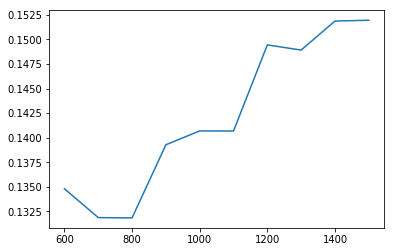

In [26]:
def evaluator(idx_segment, params=params_svr_example):
    partial_results = []
    domain = np.arange(600, 1600, 100)
    for cutoff in domain:
        result = compute_svr_r2(idx_segment[: cutoff], params=params)
        partial_results.append(result)
        
    plt.plot(domain, partial_results)
    return np.array(partial_results).mean()

evaluator(idx_segment=baseline_idxs[100:])

# To compare

In [14]:
# SVR
def compute_svr(labeled_idx, params=params_svr_example):
    svr = SVR(**params)
    svr.fit(x_train[labeled_idx], y_train[labeled_idx])
    return svr.score(x_val, y_val)


compute_svr(labeled_idx=baseline_idxs, params=params_svr_example)

0.08870205977983259

In [15]:
# SVR - BAGGING
def compute_svr_bagging(labeled_idx, params):
    svr = SVR(**params)
    brsvr = BaggingRegressor(base_estimator=svr, n_estimators=10, n_jobs=8, max_samples=2/3, bootstrap=False)
    brsvr.fit(x_train[labeled_idx], y_train[labeled_idx])
    return brsvr.score(x_val, y_val)


compute_svr_bagging(labeled_idx=baseline_idxs, params=params_svr_example)

0.09890539201541315

In [16]:
# XGBRegressor - to compare
params_xgb_example = {
    'max_depth':3,
    'min_child_weight':10,
    'learning_rate':0.3,
    'subsample':0.5,
    'colsample_bytree':0.6,
    'obj':'reg:linear',
    'n_estimators':1000,
    'eta':0.3,
    'silent': True,
    "reg": "squarederror"
}

def compute_xgbregressor(labeled_idx):
    dtrain = xgb.DMatrix(x_train[labeled_idx], y_train[labeled_idx])
    dval = xgb.DMatrix(x_val, y_val)
    evallist  = [(dtrain,'train'),(dval,'eval')]
    clf = xgb.train(params=params_xgb_example, dtrain=dtrain, evals=evallist, num_boost_round=1000, verbose_eval=False)
    dval = xgb.DMatrix(x_val)
    y_pred = clf.predict(dval)
    return R2_1(y_val, y_pred)


compute_xgbregressor(labeled_idx=baseline_idxs)

-0.009059872184214779

### Hyperparameters

In [17]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import stochastic
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
def upgrade_params(base_params, best_params, verbose=1):
    best_params = round_params(best_params)
    best_params = {**base_params, **best_params}
    best_params["verbose"] = verbose
    return best_params

hp_params = {
    "gamma": hp.uniform("gamma", 10**-3, 10**0),
    "epsilon": hp.uniform("epsilon", 10**-3, 10**0),
    "C": hp.uniform("C", 10**0, 10**1)   
}
# example -> operationalization of stochastic expression
stochastic.sample(hp_params)

{'C': 4.34069907343485,
 'epsilon': 0.23534232084916934,
 'gamma': 0.46125690545244846}

In [19]:
def find_best_params_hyperopt(labeled_idx):
    base_params = {
        "kernel": "rbf",
        "shrinking": False
    }
    def svm_objective(params):
        hp_params_svm = {**params, **base_params}
        svr_regressor = SVR(**params)    
        svr_regressor.fit(x_train[labeled_idx], y_train[labeled_idx])

        y_pred = svr_regressor.predict(x_val)
        mse = mean_squared_error(y_val, y_pred)
        
        return{'loss': mse, 'status': STATUS_OK }
  
    trials = Trials()
    best = fmin(
        fn = svm_objective,
        space = hp_params,
        algo = tpe.suggest,
        max_evals = 30,
        trials = trials
    )
    # random seed ?
    clear_output(wait=True)
    
    return upgrade_params(base_params=base_params, best_params=best, verbose=0)

In [20]:
best_params = find_best_params_hyperopt(labeled_idx=baseline_idxs)
best_params

{'kernel': 'rbf',
 'shrinking': False,
 'C': 2.4061,
 'epsilon': 0.1718,
 'gamma': 0.8803,
 'verbose': 0}

-8.407749591232408

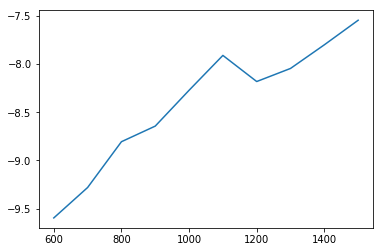

In [21]:
evaluator(idx_segment=baseline_idxs, params=best_params)

# Coreset

In [22]:
domain = np.arange(x_train.shape[0])

In [ ]:
# nofGames desceanding
sizes = (np.arange(10) + 6) * 100
initial_labeled_idx = np.arange(sizes[0])
initial_unlabeled_idx = np.setdiff1d(domain, initial_labeled_idx)

In [27]:
# kmeans
initial_labeled_idx = baseline_idxs[100: 700]
initial_unlabeled_idx = np.setdiff1d(domain, initial_labeled_idx)

# Active Learning

In [29]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling
from tqdm import tqdm

In [30]:
def build_committee(params, labeled_idx, n_estimators=5):

    learner_list = [ActiveLearner(
        estimator=SVR(**params),
        X_training=x_train[labeled_idx],
        y_training=y_train[labeled_idx],
        bootstrap_init=True
    ) for idx in np.arange(n_estimators)
                   ]
    committee = CommitteeRegressor(
        learner_list=learner_list,
        query_strategy=max_std_sampling
    )
    return committee


def query_committee(committee, unlabeled_idx, n_queries=10, n_inst_in_query=10):
    new_idxs = []
    for idx in tqdm(np.arange(n_queries)):
        query_idx, _ = committee.query(x_train[unlabeled_idx], n_instances=n_inst_in_query)
        proper_query_idx = unlabeled_idx[query_idx]
        committee.teach(x_train[proper_query_idx], y_train[proper_query_idx].ravel())
        unlabeled_idx = np.setdiff1d(unlabeled_idx, [proper_query_idx]) if n_inst_in_query == 1 else np.setdiff1d(unlabeled_idx, proper_query_idx)
        new_idxs.append(proper_query_idx)
    
    new_idxs = np.concatenate(new_idxs)
    assert len(new_idxs) == (n_queries * n_inst_in_query)
    return new_idxs, unlabeled_idx, committee
        

## Cycle

In [ ]:
def update_dict(labeled_idx, committee, params):
    step_dict = dict(zip(col_names, np.zeros(len(col_names))))
    step_dict["svm"] = compute_svr(labeled_idx, params = params)
    step_dict["svr_bagging"] = compute_svr_bagging(labeled_idx, params=params)
    step_dict["xgbregressor"] = compute_xgbregressor(labeled_idx)
    step_dict["committee_initial"] = R2_1(y_val, committee.predict(x_val))


In [1]:
# dwie wersje, wybieram parametry początkowe na początku pętli, albo z zewnątrz
def al_in_cycle(labeled_idx, unlabeled_idx, params, n_loop=10):
    markered_path = "results_idxs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    param_name = ["epsilon", "C", "gamma"]
    sequential_params = [[params[name] for name in param_name]]
    df_results = pd.DataFrame(columns=["svm", "svr_bagging", "xgbregressor", "committee_before", "committee_after"])    
    
    
    for step in np.arange(n_loop):
        np.save(file="{}/idxs_size_{}".format(markered_path, 600 + 100*step), arr=labeled_idx)
                
        # get committee of svr
        committee = build_committee(params=params, labeled_idx=labeled_idx)
        step_dict = get_step_dict(labeled_idx, committee, params)
        
        # committee is updating inside query function
        print("this is step nb: {}".format(step), df_results)
        new_idxs, unlabeled_idx, committee = query_committee(committee, unlabeled_idx, n_queries=5, n_inst_in_query=20)
        
        #update dataframe with results
        step_dict["committee_queried"] = R2_1(y_val, committee.predict(x_val))
        df_results = df_results.append(pd.Series(step_dict), ignore_index=True)

        # update idx, unlabeled_idx have been updated inside query loop
        labeled_idx = np.concatenate([labeled_idx, new_idxs])
        
#         params = find_best_params_hyperopt(labeled_idx=labeled_idx)
        sequential_params.append([params[name] for name in param_name])

        
    np.save(file="{}/idxs_size_{}".format(markered_path, 600 + 100*n_loop), arr=labeled_idx)
    # get committee of svr
    committee = build_committee(params=params, labeled_idx=labeled_idx)
    step_dict = get_step_dict(labeled_idx, committee, params)
    
    #update dataframe with last results
    step_dict["committee_queried"] = step_dict["committee_initial"]
    df_results = df_results.append(pd.Series(step_dict), ignore_index=True)
        
    return labeled_idx, sequential_params, df_results

In [32]:
closing_idx, sequential_params, df_results = al_in_cycle(
    labeled_idx=initial_labeled_idx,
    unlabeled_idx=initial_unlabeled_idx,
    params=params_svr_example,
    n_loop=30
)

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 0
      svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.1348      0.13382      0.030457          0.123556              0.0


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 1
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 2
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 3
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216
3  0.133073     0.142928     -0.248260          0.108564         0.133073


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 4
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216
3  0.133073     0.142928     -0.248260          0.108564         0.133073
4 -0.075148     0.047233     -0.152929         -0.116266        -0.075148


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 5
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216
3  0.133073     0.142928     -0.248260          0.108564         0.133073
4 -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5  0.045111     0.075261     -0.140512          0.019267         0.045111


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 6
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216
3  0.133073     0.142928     -0.248260          0.108564         0.133073
4 -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5  0.045111     0.075261     -0.140512          0.019267         0.045111
6  0.110173     0.112290     -0.097071          0.057635         0.110173


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 7
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216
3  0.133073     0.142928     -0.248260          0.108564         0.133073
4 -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5  0.045111     0.075261     -0.140512          0.019267         0.045111
6  0.110173     0.112290     -0.097071          0.057635         0.110173
7  0.097507     0.108384     -0.155341          0.059008         0.097507


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 8
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216
3  0.133073     0.142928     -0.248260          0.108564         0.133073
4 -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5  0.045111     0.075261     -0.140512          0.019267         0.045111
6  0.110173     0.112290     -0.097071          0.057635         0.110173
7  0.097507     0.108384     -0.155341          0.059008         0.097507
8  0.125656     0.146298     -0.186432          0.131710         0.125656


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 9
        svm  svr_bagging  xgbregressor  committee_before  committee_after
0  0.134800     0.133820      0.030457          0.123556         0.000000
1  0.109566     0.107554     -0.144505          0.098920         0.109566
2  0.132216     0.122569     -0.171722          0.117752         0.132216
3  0.133073     0.142928     -0.248260          0.108564         0.133073
4 -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5  0.045111     0.075261     -0.140512          0.019267         0.045111
6  0.110173     0.112290     -0.097071          0.057635         0.110173
7  0.097507     0.108384     -0.155341          0.059008         0.097507
8  0.125656     0.146298     -0.186432          0.131710         0.125656
9  0.131010     0.128326     -0.113989          0.143659         0.131010


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 10
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 11
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740


  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 12
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 13
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 14
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 15
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 16
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 17
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 18
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 19
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 20
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 21
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 22
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 23
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 24
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 25
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 26
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 27
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 28
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

  0%|          | 0/5 [00:00<?, ?it/s]

this is step nb: 29
         svm  svr_bagging  xgbregressor  committee_before  committee_after
0   0.134800     0.133820      0.030457          0.123556         0.000000
1   0.109566     0.107554     -0.144505          0.098920         0.109566
2   0.132216     0.122569     -0.171722          0.117752         0.132216
3   0.133073     0.142928     -0.248260          0.108564         0.133073
4  -0.075148     0.047233     -0.152929         -0.116266        -0.075148
5   0.045111     0.075261     -0.140512          0.019267         0.045111
6   0.110173     0.112290     -0.097071          0.057635         0.110173
7   0.097507     0.108384     -0.155341          0.059008         0.097507
8   0.125656     0.146298     -0.186432          0.131710         0.125656
9   0.131010     0.128326     -0.113989          0.143659         0.131010
10  0.134128     0.153063     -0.057568          0.088818         0.134128
11  0.159740     0.168539     -0.086358          0.142409         0.159740
12  0

100%|██████████| 5/5 [10:28<00:00, 125.62s/it]


-0.07550254276736866

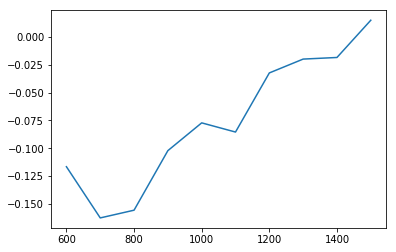

In [48]:
evaluator(idx_segment=closing_idx[-1500: ], params=params_svr_example)

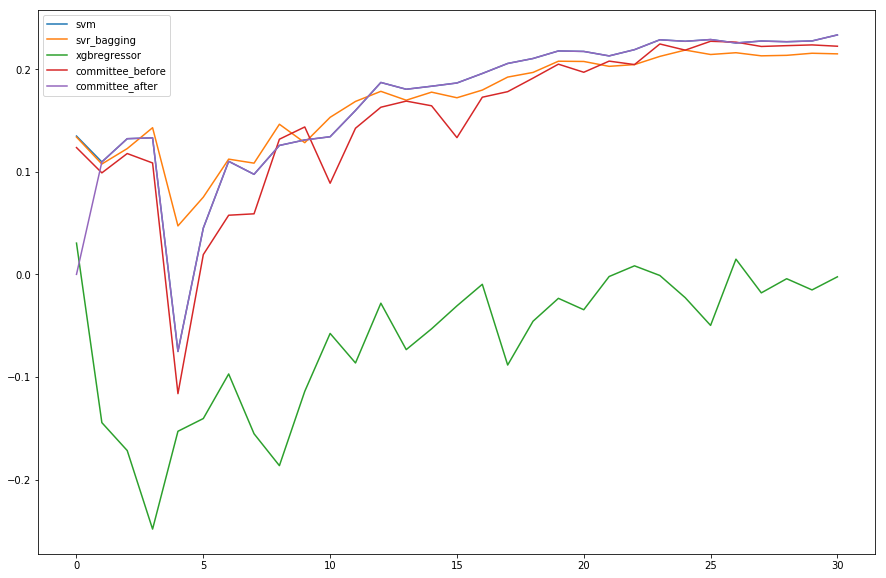

In [64]:
df_results.plot(kind="line", figsize=(15, 10));

# Save model

In [ ]:
with open('submmition/hw3_bk_sub3.txt', 'a') as f:
    for idx in range(len(sequential_idxs)):
        ind_text = ','.join(list(map(str, sequential_idxs[idx])))
        params_test = ';'.join(list(map(str, sequential_params[idx])))
        text = ';'.join([params_test, ind_text])
        f.write(text + '\n')